In [1]:
import os
import shutil
import sys

import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

# local
from utils import *
sys.path.append('../imaging-utils')
from image_arrays import *

### Activate interactive plotting
By default, inline plots are static. Here we specify one of two options (comment out the undesired command) that will open plots with GUI controls for us.
- **qt ->** figures opened in windows outside the notebook
- **notebook ->** figures within notebook underneath generating cell.

In [2]:
# %matplotlib qt 
%matplotlib notebook

In [3]:
base_path = "/mnt/Data/prerna_velocity/"
data_path = os.path.join(base_path, "2021_05_11")

In [4]:
vel_data = {
    depth: {
        int(d): np.stack(
            [
                io.imread(os.path.join(data_path, depth, d, f))
                for f in os.listdir(os.path.join(data_path, depth, d))
                if (f.endswith(".tiff") or f.endswith(".tif"))
            ],
            axis=0
        )
        for d in os.listdir(os.path.join(data_path, depth))
        if (os.path.isdir(os.path.join(data_path, depth, d)) and d.isnumeric())        
    }
    for depth in ["DD", "PD"]
}

n_trials, n_frames, y_sz, x_sz = vel_data["DD"][300].shape 
recs_xaxis = np.arange(n_frames) * (1 / 565) 
print("velocity stack shape:", vel_data["DD"][300].shape)

velocity stack shape: (1, 4500, 12, 512)


<IPython.core.display.Javascript object>


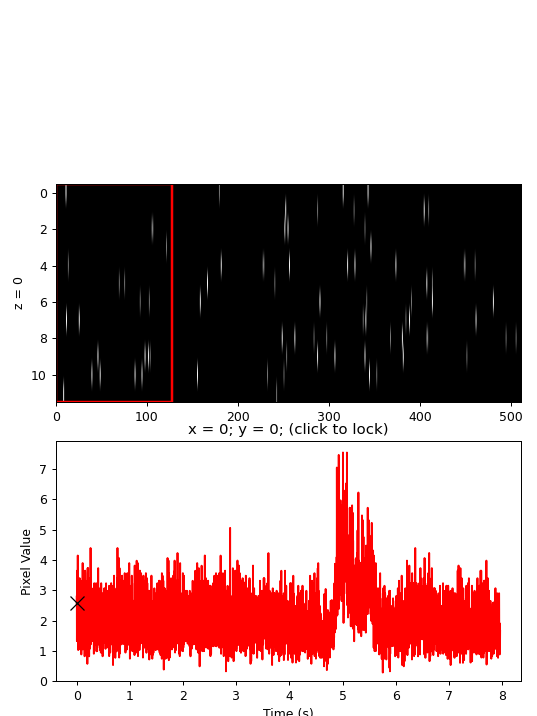

In [5]:
stack_plot = StackExplorer(
    vel_data["DD"][300],
    zaxis=recs_xaxis,
    delta=5,
    roi_sz=(128, 12),
    vmin=0,
    figsize=(6, 8)
)
stack_plot.ax[0].set_aspect(20)
stack_plot.ax[1].set_xlabel("Time (s)")
stack_plot.ax[1].set_ylabel("Pixel Value")
stack_plot.fig.show()

### Grid ROI placement using Quality Index acceptance threshold
Take `grid_w` by `grid_h` beams from the scan field and discard those that do not meet the `min_qi` threshold.

In [6]:
grid_w = 128
grid_h = 12

def aligned_avg(avg_recs):
    filtered = np.stack([savgol_filter(r, 71, 3) for r in avg_recs], axis=0)
    max_idxs = np.argmax(filtered, axis=1)
    shifts = max_idxs - np.min(max_idxs)
    trim = np.max(shifts)
    aligned = np.mean(
        [r[s:(-trim + s) if s != trim else None] for r, s in zip(avg_recs, shifts)],
        axis=0
    )
    return aligned
    
grid_recs, avg_grid_recs, aligned_grid_avg, grid_locs = {}, {}, {}, {}
for depth, vels in vel_data.items():
    grid_recs[depth], avg_grid_recs[depth], grid_locs[depth], = {}, {}, {}
    aligned_grid_avg[depth] = {}
    for v, stack in vels.items():
        recs, locs = [], []
        for x0 in range(0, x_sz, grid_w):
            for y0 in range(0, y_sz, grid_h):
                beams = np.mean(stack[:, :, y0:y0 + grid_h, x0:x0 + grid_w], axis=(2, 3))
                recs.append(beams)
                locs.append([x0, y0])        
        grid_recs[depth][v] = np.stack(recs, axis=1)
        avg_grid_recs[depth][v] = np.mean(grid_recs[depth][v], axis=0)
        grid_locs[depth][v] = np.stack(locs, axis=0)
        aligned_grid_avg[depth][v] = aligned_avg(avg_grid_recs[depth][v])

<IPython.core.display.Javascript object>


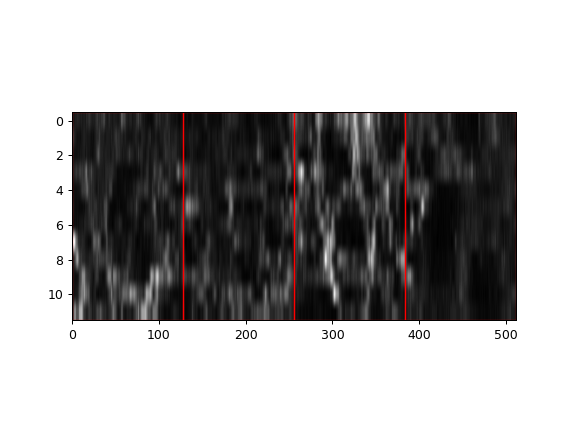

In [7]:
depth = "DD"
vel = 500

mean_stack_proj = np.mean(vel_data[depth][vel], axis=(0,1))

half_w = grid_w / 2
half_h = grid_h / 2
grid_fig, grid_ax = plt.subplots(1)

grid_ax.imshow(mean_stack_proj, cmap="gray", aspect=20)
for (x, y) in grid_locs[depth][vel]:
    grid_ax.add_patch(
        Rectangle(
            (x - .5, y - .5),  # grid offset
            grid_w, 
            grid_h, 
            fill=False,
            color="red",
            linewidth=1,
            linestyle="-"
        )
    )

<IPython.core.display.Javascript object>


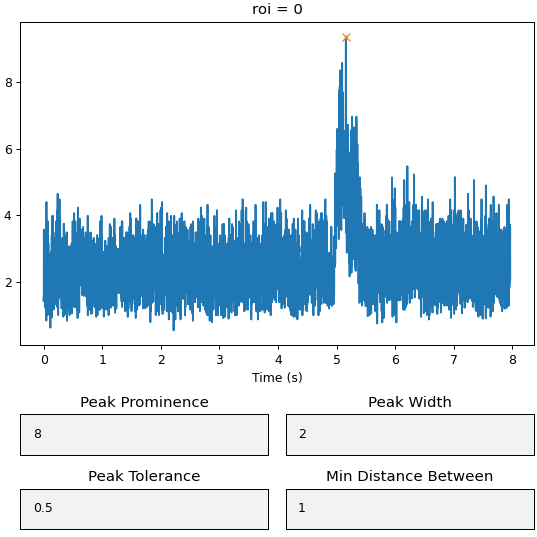

In [8]:
peak_explorer = PeakExplorer(
    recs_xaxis, 
    grid_recs[depth][vel][0],
    prominence=8,
    width=2,
    tolerance=.5,
    distance=1
)

In [29]:
grid_idx = 2

fits, fitted_recs = {}, {}
for depth, vels in aligned_grid_avg.items():
# for depth, vels in avg_grid_recs.items():
    fits[depth], fitted_recs[depth] = {}, {}
    for v, recs in vels.items():
        y = savgol_filter(recs, 51, 3)
#         y = savgol_filter(recs[grid_idx], 51, 3)
        i0 = find_rise_start(y, step=15)
        y_sub = y[i0:] - y[i0]
        y_norm = y_sub / y_sub.max()
        x_trunc = np.arange(len(y) - i0) * (1 / 565)

        fitter = BiexpFitter(0.05, .25, norm_amp=True)
        fitter.fit(x_trunc, y_norm)
        g = fitter.calc_g(x_trunc)
        print(
            "[%s, %i] -> tau1: %.3f; tau2: %.3f" %
            (
                depth,
                v,
                fitter.results.params["tau1"], 
                fitter.results.params["tau2"]
            )
        )
        fits[depth][v] = {"g": g, **fitter.results.params}
        fitted_recs[depth][v] = y_norm

[DD, 1000] -> tau1: 0.057; tau2: 0.116
[DD, 2000] -> tau1: 0.055; tau2: 0.055
[DD, 300] -> tau1: 0.171; tau2: 0.191
[DD, 3000] -> tau1: 0.001; tau2: 0.001
[DD, 4000] -> tau1: 0.041; tau2: 0.041
[DD, 500] -> tau1: 0.117; tau2: 0.117
[DD, 5000] -> tau1: 0.001; tau2: 0.001
[PD, 1000] -> tau1: 0.108; tau2: 0.108
[PD, 2000] -> tau1: 0.059; tau2: 0.059
[PD, 300] -> tau1: 0.180; tau2: 0.182
[PD, 3000] -> tau1: 0.001; tau2: 0.001
[PD, 4000] -> tau1: 0.001; tau2: 0.001
[PD, 500] -> tau1: 0.164; tau2: 0.169
[PD, 5000] -> tau1: 0.001; tau2: 0.001


<IPython.core.display.Javascript object>


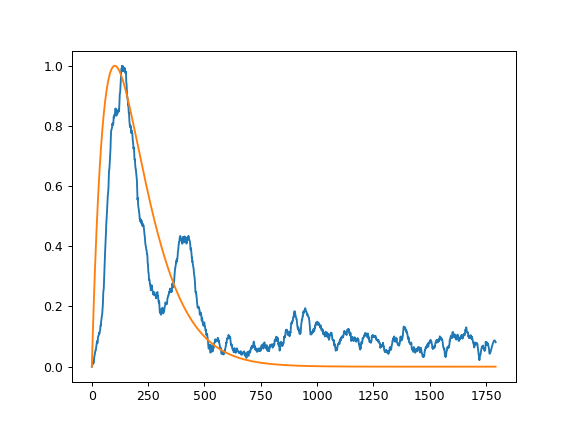

In [43]:
depth = "DD"
vel = 300
ff, aa = plt.subplots(1)
aa.plot(fitted_recs[depth][vel])
aa.plot(fits[depth][vel]["g"])

<IPython.core.display.Javascript object>


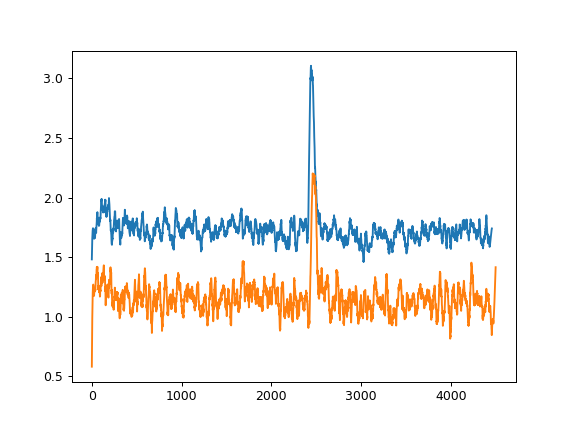

In [16]:
ff1, aa1 = plt.subplots(1)
aa1.plot(savgol_filter(aligned_grid_avg[depth][vel], 51, 3))
aa1.plot(savgol_filter(avg_grid_recs[depth][vel][grid_idx], 51, 3))